In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import jax.numpy as jnp
from jax import jit, random
from sgmcmcjax.util import build_grad_log_post
import time

import numpyro
from numpyro.infer import NUTS, MCMC

import context
from models.logistic_regression.logistic_regression_model import gen_data, loglikelihood, logprior, accuracy
from tuning.ksd import imq_KSD
from util import wait_until_computed


## Logistic regression

In [2]:
key = random.PRNGKey(42)
dim = 10
Ndata = 1_000_000

theta_true, X, y_data = gen_data(key, dim, Ndata)

# testing and training data
num_train = int(Ndata*0.8)

X_train = X[:num_train]
X_test = X[num_train:]

y_train = y_data[:num_train]
y_test = y_data[num_train:]
print(X_train.shape, X_test.shape)
data = (X_train, y_train)


generating data, with N=1,000,000 and dim=10
(800000, 10) (200000, 10)


### run NUTS for 20K iterations

- ESS = 6759
- Takes 4 minutes to run
- predictive accuracy: 93.71

In [4]:

grad_log_post_LR = build_grad_log_post(loglikelihood, logprior, data, with_val=True)

@jit
def potential_log_reg(theta):
    return -grad_log_post_LR(theta, *data)[0]



In [5]:
potential_log_reg(theta_true)

DeviceArray(115910.04, dtype=float32)

In [6]:

nuts_sampler = MCMC(NUTS(potential_fn=potential_log_reg), num_samples=20000, 
                 num_warmup=1000, num_chains=1, progress_bar=True)


init_params = jnp.zeros(theta_true.shape[0])
    
starttime = time.time()
key = random.PRNGKey(0)
nuts_sampler.run(key, init_params=init_params)

samples_nuts = nuts_sampler.get_samples(True)
wait_until_computed(samples_nuts)
endtime = time.time()
print(f"Running time: {endtime-starttime:.2f} sec")

samples_nuts = samples_nuts[0]

sample: 100%|██████████| 21000/21000 [44:34<00:00,  7.85it/s, 7 steps of size 2.67e-01. acc. prob=0.92]   


Running time: 2676.70 sec


Maximum IAT 3.6


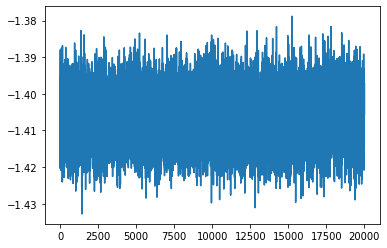

In [14]:
from emcee.autocorr import integrated_time

max_IAT = max([integrated_time(samples_nuts[:,idx], tol=100) for idx in range(10)])[0]
print(f"Maximum IAT {max_IAT:.1f}")


plt.plot(samples_nuts[:,0])

In [15]:
20000/max_IAT

5599.095178927132

In [13]:
print(accuracy(samples_nuts[::100], X_test, y_test))

0.93895


In [10]:
NUTS_stds = samples_nuts.std(axis=0)

print(NUTS_stds)

[0.00679838 0.00646107 0.01106637 0.00668608 0.00922326 0.00671594
 0.01065684 0.00812546 0.01978116 0.01162364]


In [11]:
# np.savetxt("outputs/LR_uncertainty_tests/NUTS_stds.txt", NUTS_stds)

# NUTS_stds = np.genfromtxt("outputs/LR_uncertainty_tests/NUTS_stds.txt")

In [12]:
ls outputs/LR_uncertainty_tests/

KSD_list/      NUTS_stds.txt


In [4]:
def get_relative_error_LR(estimate, ground_truth=NUTS_stds):
    return np.linalg.norm(estimate - ground_truth)/np.linalg.norm(ground_truth)

